# PSTH Analysis - Interactive Notebook

## Data Structure:
- **spikes_time_adjusted.csv**: Spike data with columns [time, unit, channel]
- **pico.csv**: Stimulus intervals with columns [Start, End]

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from psth_analysis import PSTHAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration & Data Loading

Set your analysis parameters here:

In [33]:
# ANALYSIS PARAMETERS - Modify these as needed
PRE_TIME = 100    # Time before stimulus onset (ms)
POST_TIME = 500   # Time after stimulus onset (ms)
BIN_SIZE = 10      # Bin size for histogram (ms)
SMOOTHING = 1      # Smoothing window (bins) - set to None for no smoothing

# Visualization parameters
PLOT_RASTER = True  # Show raster plots
MAX_UNITS_GRID = 20 # Maximum units to show in grid plot
FIGURE_DPI = 150    # Figure resolution

print(f"Analysis window: -{PRE_TIME}ms to +{POST_TIME}ms")
print(f"Bin size: {BIN_SIZE}ms")
print(f"Smoothing: {SMOOTHING} bins" if SMOOTHING else "No smoothing")

Analysis window: -100ms to +500ms
Bin size: 10ms
Smoothing: 1 bins


In [34]:
# Initialize the PSTH analyzer
analyzer = PSTHAnalyzer(
    spikes_file='spikes_time_adjusted.csv',
    intervals_file='pico.csv'
)

print(f"\nData loaded successfully!")
print(f"Total units: {analyzer.n_units}")
print(f"Total channels: {analyzer.n_channels}")
print(f"Unit range: {min(analyzer.units)} - {max(analyzer.units)}")
print(f"Channel range: {min(analyzer.channels)} - {max(analyzer.channels)}")

Loading data...
Loaded 288393 spikes
Loaded 28336 intervals
Data summary: 45 units, 20 channels
Time range: 358907 - 27276990

Data loaded successfully!
Total units: 45
Total channels: 20
Unit range: 1 - 45
Channel range: 4 - 31


## PSTH Computation

Compute the PSTH for all or selected units:

In [50]:
# Option 1: Analyze all units
#selected_units = None  # Will analyze all units

# Option 2: Analyze specific units (uncomment and modify as needed)
selected_units = [25]  # Example unit selection

# Option 3: Analyze top N units by spike count
# top_n = 10
# unit_counts = analyzer.spikes_df['unit'].value_counts()
# selected_units = unit_counts.head(top_n).index.tolist()
# print(f"Selected top {top_n} units: {selected_units}")

# Compute PSTH
print("Computing PSTH...")
psth_data = analyzer.compute_psth(
    pre_time=PRE_TIME,
    post_time=POST_TIME,
    bin_size=BIN_SIZE,
    units=selected_units,
    smoothing_window=SMOOTHING
)

print(f"PSTH computed for {len(psth_data)} units")
print(f"Time bins: {len(list(psth_data.values())[0]['bin_centers'])}")

Computing PSTH...
Computing PSTH for 1 units...
Window: -100ms to +500ms, bin size: 10ms
PSTH computed for 1 units
Time bins: 60


## Individual Unit Analysis



In [51]:
# Select a unit to examine in detail
# You can change this to any unit ID in your data
EXAMPLE_UNIT = list(psth_data.keys())[0]  # First available unit

print(f"Analyzing Unit {EXAMPLE_UNIT} in detail")
print(f"Available units: {sorted(list(psth_data.keys()))}")

# Display unit statistics
unit_data = psth_data[EXAMPLE_UNIT]
print(f"\nUnit {EXAMPLE_UNIT} Statistics:")
print(f"- Total spikes in analysis window: {unit_data['total_spikes']}")
print(f"- Valid intervals: {unit_data['valid_intervals']}")
print(f"- Peak firing rate: {np.max(unit_data['firing_rate']):.2f} Hz")
print(f"- Average firing rate: {np.mean(unit_data['firing_rate']):.2f} Hz")

Analyzing Unit 25 in detail
Available units: [25]

Unit 25 Statistics:
- Total spikes in analysis window: 3341
- Valid intervals: 3108
- Peak firing rate: 4.86 Hz
- Average firing rate: 1.79 Hz


<Figure size 1200x800 with 0 Axes>

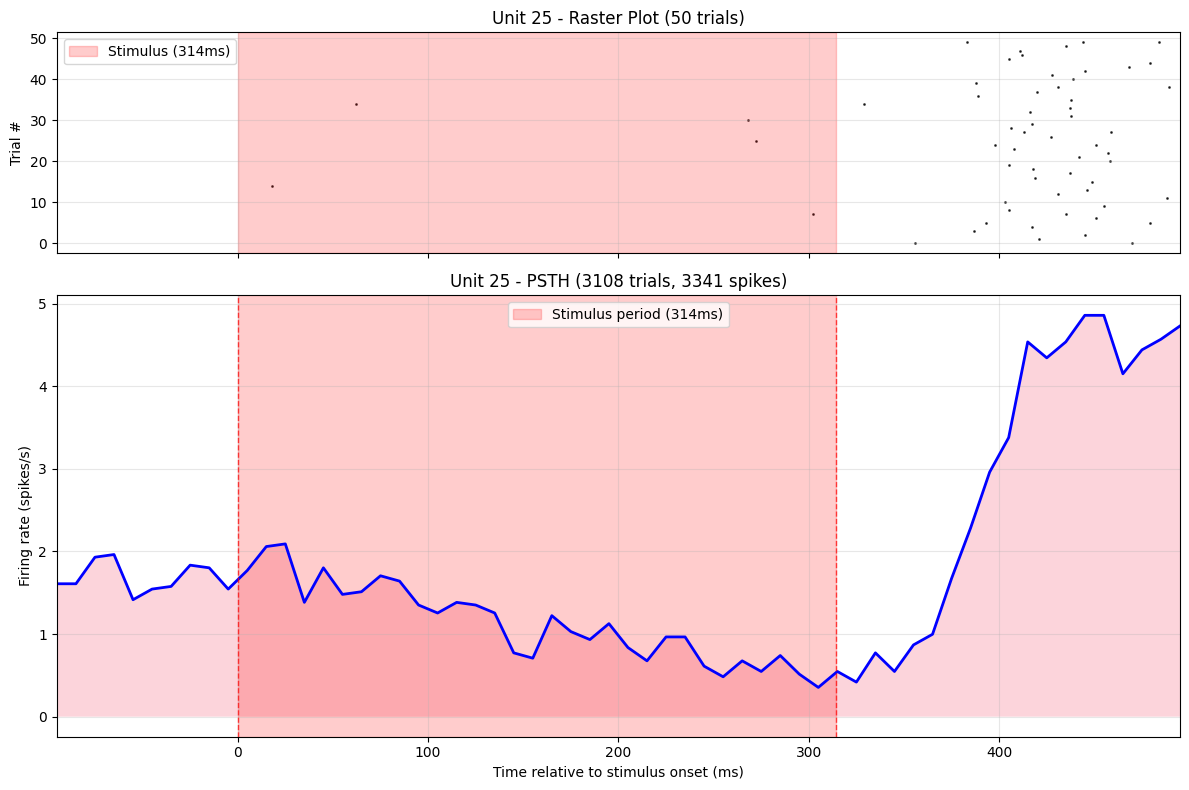

In [52]:
# Plot detailed PSTH for the selected unit
plt.figure(figsize=(12, 8))
analyzer.plot_psth_single_unit(EXAMPLE_UNIT, show_raster=PLOT_RASTER)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

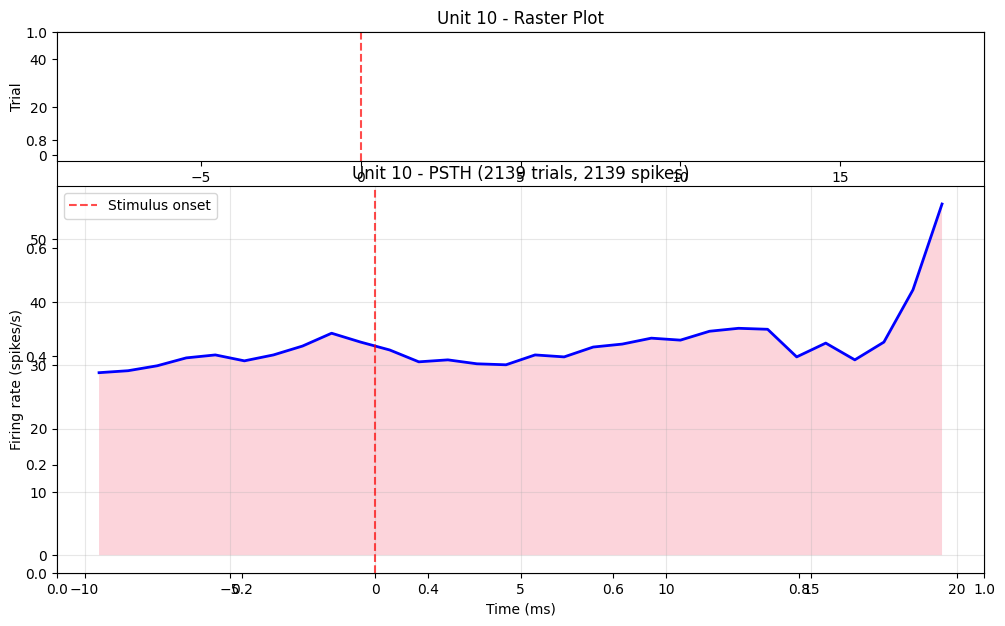


Unit 10 Statistics:
- Total spikes: 2139
- Valid intervals: 2139
- Peak firing rate: 55.48 Hz
- Baseline firing rate (first 25%): 30.43 Hz


In [13]:
# Interactive unit selection - change UNIT_TO_PLOT to explore different units
UNIT_TO_PLOT = 10  # Change this value to any unit you want to examine

if UNIT_TO_PLOT in psth_data:
    plt.figure(figsize=(12, 8))
    analyzer.plot_psth_single_unit(UNIT_TO_PLOT, show_raster=PLOT_RASTER)
    plt.tight_layout()
    plt.show()
    
    # Show statistics for this unit
    unit_data = psth_data[UNIT_TO_PLOT]
    print(f"\nUnit {UNIT_TO_PLOT} Statistics:")
    print(f"- Total spikes: {unit_data['total_spikes']}")
    print(f"- Valid intervals: {unit_data['valid_intervals']}")
    print(f"- Peak firing rate: {np.max(unit_data['firing_rate']):.2f} Hz")
    print(f"- Baseline firing rate (first 25%): {np.mean(unit_data['firing_rate'][:len(unit_data['firing_rate'])//4]):.2f} Hz")
else:
    print(f"Unit {UNIT_TO_PLOT} not found in data. Available units: {sorted(list(psth_data.keys()))}")

## Population Analysis

Now let's look at population-level patterns:

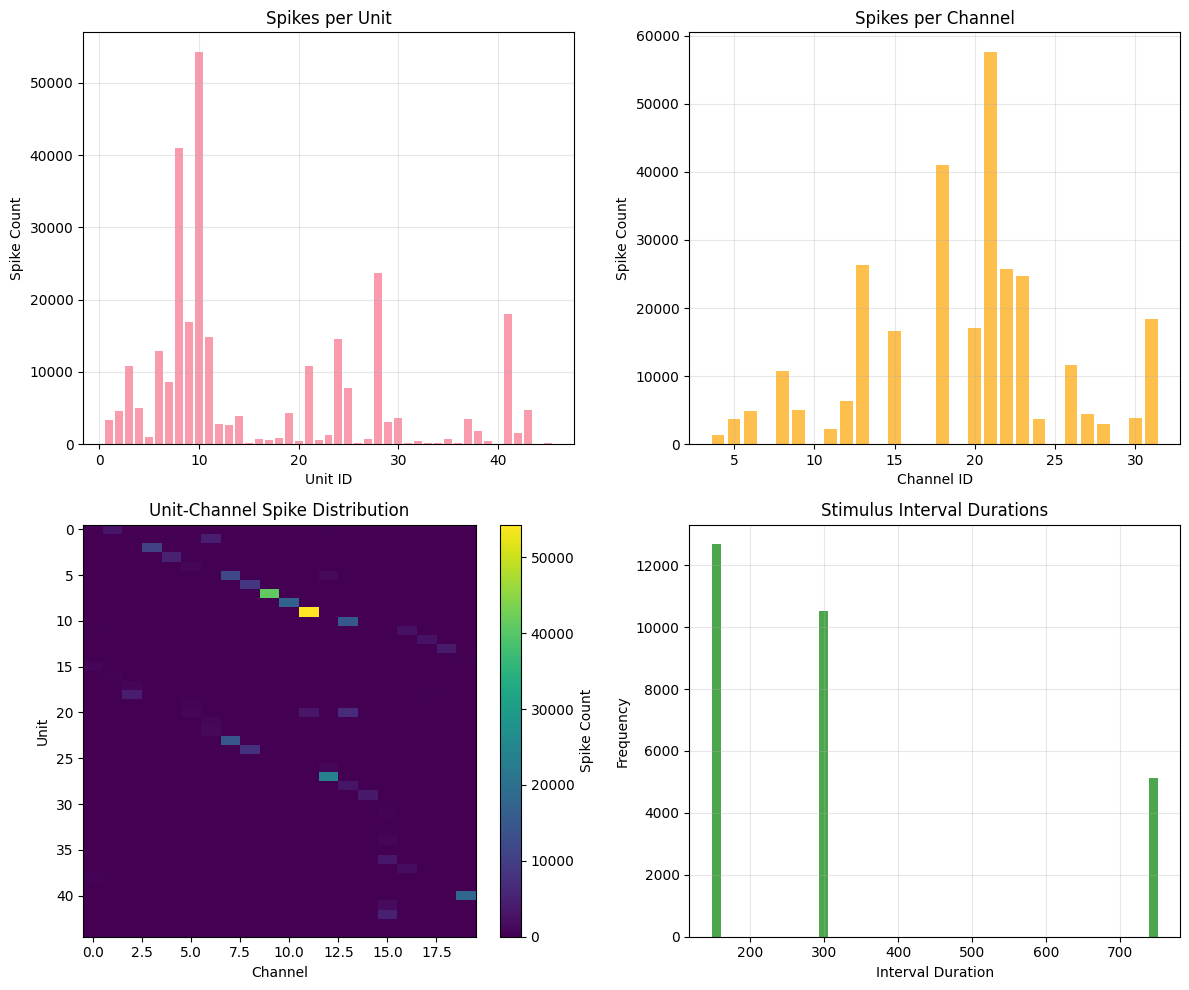

Average interval duration: 314.4 ± 215.6


In [ ]:
# Plot distribution of units and channels
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unit distribution
unit_counts = analyzer.spikes_df['unit'].value_counts().sort_index()
axes[0,0].bar(unit_counts.index, unit_counts.values, alpha=0.7)
axes[0,0].set_xlabel('Unit ID')
axes[0,0].set_ylabel('Spike Count')
axes[0,0].set_title('Spikes per Unit')
axes[0,0].grid(True, alpha=0.3)

# Channel distribution
channel_counts = analyzer.spikes_df['channel'].value_counts().sort_index()
axes[0,1].bar(channel_counts.index, channel_counts.values, alpha=0.7, color='orange')
axes[0,1].set_xlabel('Channel ID')
axes[0,1].set_ylabel('Spike Count')
axes[0,1].set_title('Spikes per Channel')
axes[0,1].grid(True, alpha=0.3)

# Unit-Channel relationship
unit_channel_df = analyzer.spikes_df.groupby(['unit', 'channel']).size().reset_index(name='spike_count')
pivot_table = unit_channel_df.pivot(index='unit', columns='channel', values='spike_count').fillna(0)

im = axes[1,0].imshow(pivot_table.values, aspect='auto', cmap='viridis', interpolation='nearest')
axes[1,0].set_xlabel('Channel')
axes[1,0].set_ylabel('Unit')
axes[1,0].set_title('Unit-Channel Spike Distribution')
plt.colorbar(im, ax=axes[1,0], label='Spike Count')

# Interval duration distribution
interval_durations = analyzer.intervals_df['End'] - analyzer.intervals_df['Start']
axes[1,1].hist(interval_durations, bins=50, alpha=0.7, color='green')
axes[1,1].set_xlabel('Interval Duration')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Stimulus Interval Durations')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average interval duration: {interval_durations.mean():.1f} ± {interval_durations.std():.1f}")

In [ ]:
# Plot PSTH grid for multiple units
units_to_plot = list(psth_data.keys())[:MAX_UNITS_GRID]
print(f"Plotting PSTH grid for {len(units_to_plot)} units")

grid_fig = analyzer.plot_psth_grid(
    units=units_to_plot,
    ncols=4,
    figsize=(16, 12),
    show_statistics=True
)
plt.show()

In [ ]:
# Population PSTH (average across units)
print("Creating population PSTH...")
pop_fig = analyzer.plot_population_psth(method='mean')
plt.show()

# Population PSTH (sum across units)
pop_sum_fig = analyzer.plot_population_psth(method='sum')
plt.show()

## Channel Analysis

Let's analyze the data from a channel perspective:

In [ ]:
# Compute channel-based analysis
print("Computing channel analysis...")
channel_data = analyzer.analyze_channels(
    pre_time=PRE_TIME,
    post_time=POST_TIME,
    bin_size=BIN_SIZE
)

print(f"Analysis computed for {len(channel_data)} channels")

# Display channel summary
print("\nChannel Summary:")
for channel, data in sorted(channel_data.items()):
    print(f"Channel {channel}: {data['n_units']} units, {data['total_spikes']} spikes, peak rate {np.max(data['firing_rate']):.1f} Hz")

In [ ]:
# Plot comprehensive channel analysis
channel_fig = analyzer.plot_channel_analysis(channel_data)
plt.show()

In [ ]:
# Channel correlation analysis
print("Computing channel correlations...")

# Create correlation matrix between channels
channels = sorted(channel_data.keys())
firing_rates_matrix = np.array([channel_data[ch]['firing_rate'] for ch in channels])

# Compute correlation matrix
correlation_matrix = np.corrcoef(firing_rates_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.title('Inter-Channel PSTH Correlation')

# Add channel labels
plt.xticks(range(len(channels)), channels)
plt.yticks(range(len(channels)), channels)

# Add correlation values to the plot
for i in range(len(channels)):
    for j in range(len(channels)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.show()

# Find most correlated channel pairs
max_corr = 0
max_pair = None
for i, ch1 in enumerate(channels):
    for j, ch2 in enumerate(channels):
        if i < j and correlation_matrix[i, j] > max_corr:
            max_corr = correlation_matrix[i, j]
            max_pair = (ch1, ch2)

if max_pair:
    print(f"\nHighest channel correlation: {max_corr:.3f} between channels {max_pair[0]} and {max_pair[1]}")

## Statistical Analysis & Summary

In [8]:
# Get comprehensive summary statistics
summary_stats = analyzer.get_summary_statistics()

print("=" * 50)
print("PSTH ANALYSIS SUMMARY")
print("=" * 50)

print(f"\nGeneral Statistics:")
print(f"- Units analyzed: {summary_stats['n_units_analyzed']}")
print(f"- Total intervals: {summary_stats['total_intervals']}")
print(f"- Data time range: {summary_stats['data_time_range']['min']:.0f} - {summary_stats['data_time_range']['max']:.0f}")

print(f"\nAnalysis Parameters:")
print(f"- Pre-stimulus time: {PRE_TIME} ms")
print(f"- Post-stimulus time: {POST_TIME} ms")
print(f"- Bin size: {BIN_SIZE} ms")
print(f"- Smoothing: {SMOOTHING} bins" if SMOOTHING else "- No smoothing applied")

# Unit-specific statistics
unit_stats = summary_stats['unit_statistics']
baseline_rates = [stats['baseline_rate'] for stats in unit_stats.values()]
peak_rates = [stats['peak_rate'] for stats in unit_stats.values()]
modulation_ratios = [stats['modulation_ratio'] for stats in unit_stats.values() if stats['modulation_ratio'] != float('inf')]

print(f"\nFiring Rate Statistics:")
print(f"- Baseline rates: {np.mean(baseline_rates):.2f} ± {np.std(baseline_rates):.2f} Hz")
print(f"- Peak rates: {np.mean(peak_rates):.2f} ± {np.std(peak_rates):.2f} Hz")
print(f"- Modulation ratios: {np.mean(modulation_ratios):.2f} ± {np.std(modulation_ratios):.2f}")

# Find most responsive units
most_responsive = sorted(unit_stats.items(), key=lambda x: x[1]['modulation_ratio'], reverse=True)[:5]
print(f"\nTop 5 Most Responsive Units:")
for unit, stats in most_responsive:
    if stats['modulation_ratio'] != float('inf'):
        print(f"- Unit {unit}: {stats['modulation_ratio']:.2f}x modulation ({stats['baseline_rate']:.1f} → {stats['peak_rate']:.1f} Hz)")

PSTH ANALYSIS SUMMARY

General Statistics:
- Units analyzed: 1
- Total intervals: 28336
- Data time range: 358907 - 27276990

Analysis Parameters:
- Pre-stimulus time: 10 ms
- Post-stimulus time: 20 ms
- Bin size: 1 ms
- Smoothing: 3 bins

Firing Rate Statistics:
- Baseline rates: 30.43 ± 0.00 Hz
- Peak rates: 55.48 ± 0.00 Hz
- Modulation ratios: 1.82 ± 0.00

Top 5 Most Responsive Units:
- Unit 10: 1.82x modulation (30.4 → 55.5 Hz)



Response Pattern Analysis:
- Responsive units (>50% increase): 1 (100.0%)
- Suppressed units (>30% decrease): 0 (0.0%)
- Non-responsive units: 0 (0.0%)


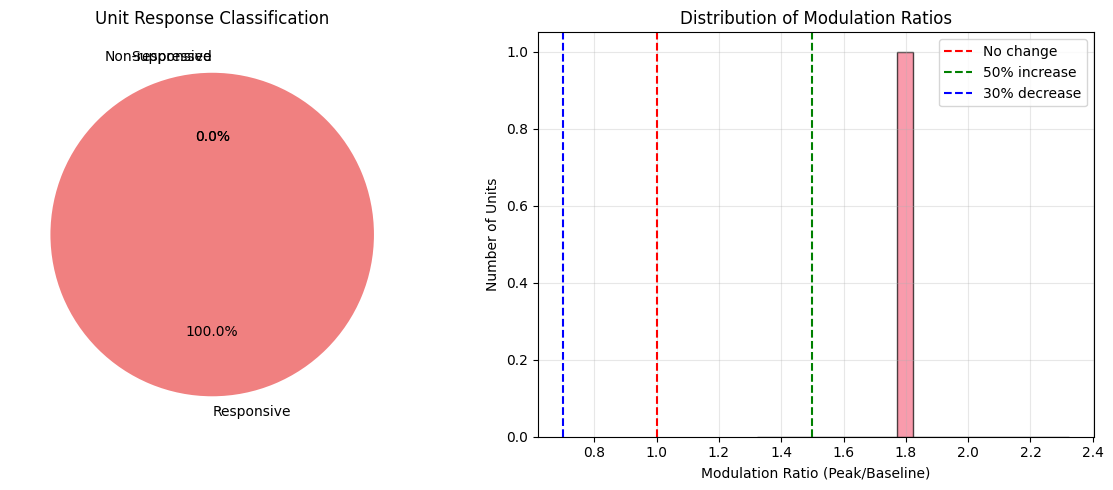

In [9]:
# Analyze response characteristics
print("\nResponse Pattern Analysis:")

# Classify units by response type
responsive_units = []
suppressed_units = []
non_responsive_units = []

for unit, stats in unit_stats.items():
    if stats['baseline_rate'] > 0:
        modulation = stats['modulation_ratio']
        if modulation > 1.5:  # 50% increase
            responsive_units.append(unit)
        elif modulation < 0.7:  # 30% decrease
            suppressed_units.append(unit)
        else:
            non_responsive_units.append(unit)
    else:
        if stats['peak_rate'] > 0:
            responsive_units.append(unit)
        else:
            non_responsive_units.append(unit)

print(f"- Responsive units (>50% increase): {len(responsive_units)} ({100*len(responsive_units)/len(unit_stats):.1f}%)")
print(f"- Suppressed units (>30% decrease): {len(suppressed_units)} ({100*len(suppressed_units)/len(unit_stats):.1f}%)")
print(f"- Non-responsive units: {len(non_responsive_units)} ({100*len(non_responsive_units)/len(unit_stats):.1f}%)")

# Plot response classification
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Response type pie chart
labels = ['Responsive', 'Suppressed', 'Non-responsive']
sizes = [len(responsive_units), len(suppressed_units), len(non_responsive_units)]
colors = ['lightcoral', 'lightskyblue', 'lightgray']

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Unit Response Classification')

# Modulation ratio distribution
valid_modulations = [stats['modulation_ratio'] for stats in unit_stats.values() 
                    if stats['modulation_ratio'] != float('inf') and stats['modulation_ratio'] < 10]

axes[1].hist(valid_modulations, bins=20, alpha=0.7, edgecolor='black')
axes[1].axvline(x=1, color='red', linestyle='--', label='No change')
axes[1].axvline(x=1.5, color='green', linestyle='--', label='50% increase')
axes[1].axvline(x=0.7, color='blue', linestyle='--', label='30% decrease')
axes[1].set_xlabel('Modulation Ratio (Peak/Baseline)')
axes[1].set_ylabel('Number of Units')
axes[1].set_title('Distribution of Modulation Ratios')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Custom Analysis Section

Use this section for your own custom analyses. You can modify parameters and explore specific aspects of your data:

In [ ]:
# CUSTOM ANALYSIS - Modify these parameters as needed

# Example: Analyze with different time windows
CUSTOM_PRE = 500   # Different pre-stimulus time
CUSTOM_POST = 1500 # Different post-stimulus time
CUSTOM_BIN = 25    # Smaller bin size for higher resolution

print(f"Running custom analysis with parameters:")
print(f"- Pre-stimulus: {CUSTOM_PRE}ms")
print(f"- Post-stimulus: {CUSTOM_POST}ms") 
print(f"- Bin size: {CUSTOM_BIN}ms")

# Compute PSTH with custom parameters
custom_psth = analyzer.compute_psth(
    pre_time=CUSTOM_PRE,
    post_time=CUSTOM_POST,
    bin_size=CUSTOM_BIN,
    units=responsive_units[:5],  # Use only the most responsive units
    smoothing_window=2
)

print(f"Custom PSTH computed for {len(custom_psth)} responsive units")

In [ ]:
# Plot custom analysis results
if custom_psth:
    # Update analyzer's psth_data temporarily for plotting
    original_data = analyzer.psth_data.copy()
    analyzer.psth_data = custom_psth
    
    # Create custom population plot
    custom_fig = analyzer.plot_population_psth(method='mean')
    plt.title(f'Custom PSTH - Responsive Units Only\n({CUSTOM_PRE}ms pre, {CUSTOM_POST}ms post, {CUSTOM_BIN}ms bins)')
    plt.show()
    
    # Restore original data
    analyzer.psth_data = original_data
else:
    print("No data available for custom analysis")

In [ ]:
# Export analysis results
print("Exporting analysis results...")

# Save summary statistics to CSV
import json

# Create a DataFrame with unit statistics
unit_stats_df = pd.DataFrame(summary_stats['unit_statistics']).T
unit_stats_df.to_csv('psth_unit_statistics.csv')
print("Unit statistics saved to 'psth_unit_statistics.csv'")

# Save channel data
channel_stats = []
for channel, data in channel_data.items():
    channel_stats.append({
        'channel': channel,
        'n_units': data['n_units'],
        'total_spikes': data['total_spikes'],
        'valid_intervals': data['valid_intervals'],
        'peak_rate': np.max(data['firing_rate']),
        'mean_rate': np.mean(data['firing_rate'])
    })

channel_stats_df = pd.DataFrame(channel_stats)
channel_stats_df.to_csv('psth_channel_statistics.csv', index=False)
print("Channel statistics saved to 'psth_channel_statistics.csv'")

print("\nAnalysis complete! Check the generated CSV files for detailed statistics.")